In [ ]:
# Loading libraries
using Dates
using DINCAE
using LinearAlgebra
using NCDatasets
using Printf
using Random
using DIVAnd
using Glob
using JSON3
using DataStructures
using IntervalSets
using CSV
using DataFrames
using Statistics
using PyPlot
include("~/Reconstruct_Points/DINCAE-benthic-traits/src/neccton_common.jl")

In [ ]:
# Define Directories
root = expanduser("~/Reconstruct_Points")

basedir   = joinpath(root, "Datasets")
moddir    = joinpath(root, "ModelOut")
moddirNew = joinpath(root, "ModelNew")
figdir    = joinpath(root, "Datasets", "Figures")
outdir    = joinpath(root, "Datasets", "Results")

datadir = joinpath(root, "Datasets", "BenthicData")
auxdir  = joinpath(root, "Datasets", "Auxdata_$(1/dlon)")

split_fname   = joinpath(root, "Datasets", "split.nc")
station_fname = joinpath(root, "Datasets", "BenthicData", "Stations", "stations.csv")

CWM_response_fname = joinpath(root, "Datasets", "BenthicData", "CWM_SxT", "cwm.csv")

env_matrix_fname = joinpath(root,"Datasets","BenthicData","Environnement","matrice environnement.txt")


In [ ]:
# Define grid
Δlon = dlon
Δlat = dlat

lonr = gridlon
latr = gridlat

xi = gridlon .+ 0 * gridlat'
yi = 0 * gridlon .+ gridlat'

grid = (lonr,latr)

@show size(lonr)


size(lonr) = (74,)


(74,)

In [ ]:
# Separate training and validation dataset
df, resp, station = df_load(station_fname,CWM_response_fname);
ds = NCDataset(split_fname);
index_train = ds["index_train"][:];
index_val = ds["index_val"][:];
close(ds)

# Define stations for training
x = df.Longitude[index_train];
y = df.Latitude[index_train];

In [ ]:
# Parametrization 
epochs = 650
probability_skip_for_training = 0.1
learning_rate_decay_epoch = 20
regularization_L2_beta = 0
upsampling_method = :nearest
learning_rate = 0.00149
batch_size = 1;
clip_grad = 5.0
save_epochs = [epochs]
enc_nfilter_internal = round.(Int,32 * 2 .^ (0:5))
jitter_std_pos = (0f0,0f0)
ntime_win = 1
skipconnections = 3:length(enc_nfilter_internal)
laplacian_penalty = 0.8f0
loss_weights_refine = (1,)
seed = 12345

laplacian_penalty = Float32(10 ^ (rand(-0..1)))
enc_nfilter_internal = round.(Int,32 * 2 .^ (0:rand(2:5)))

save_epochs = [epochs]

const T = Float32
const F = Float32

Atype = Array{F}



1-element Vector{Int64}:
 650

In [ ]:
# Save results

timestamp = Dates.format(Dates.now(),"yyyy-mm-ddTHHMMSS")
outdir = joinpath(basedir,"Results","DINCAE-$(timestamp)")
mkpath(outdir)
paramsname = joinpath(outdir,"params.json")


open(paramsname,"w") do f
    JSON3.pretty(f,OrderedDict(
        "laplacian_penalty" => laplacian_penalty,
        "epochs" => epochs,
        "batch_size" => batch_size,
        "enc_nfilter_internal" => enc_nfilter_internal,
        "clip_grad" => clip_grad,
        "regularization_L2_beta" => regularization_L2_beta,
        "ntime_win" => ntime_win,
        "upsampling_method" => upsampling_method,
        "loss_weights_refine" => loss_weights_refine,
        "save_epochs" => save_epochs,
        "skipconnections" => skipconnections,
        "dlon" => dlon,
        "dlat" => dlat,
        "jitter_std_pos" => jitter_std_pos,
        "probability_skip_for_training" => probability_skip_for_training,
        "learning_rate" => learning_rate,
        "learning_rate_decay_epoch" => learning_rate_decay_epoch,
        "seed" => seed,
    ))
end

In [ ]:
# Load co-variables from NEMO-BMHBI model and sediment type

covars_fname = [
    #(filename = "mean_oxygenbot.nc", varname = "mean_oxygenbot", errvarname = nothing),
    #(filename = "std_oxygenbot.nc",  varname = "std_oxygenbot",  errvarname = nothing),
    #(filename = "mean_DOX.nc",      varname = "mean_dox",      errvarname = nothing),
    #(filename = "std_DOX.nc",       varname = "std_dox",       errvarname = nothing),
    #(filename = "low_DOX.nc",       varname = "low_dox",       errvarname = nothing),
    
    (filename = "resized_clim_2008_2018.nc",       varname = "avg_oxygen",       errvarname = nothing),
    (filename = "resized_clim_2008_2018.nc",       varname = "avg_fCSED",       errvarname = nothing),
    (filename = "resized_clim_2008_2018.nc",       varname = "avg_sCSED",       errvarname = nothing),
    (filename = "resized_clim_2008_2018.nc",       varname = "avg_POC",       errvarname = nothing),
    (filename = "resized_clim_2008_2018.nc",       varname = "avg_Botflux",       errvarname = nothing),
    (filename = "resized_clim_2008_2018.nc",       varname = "Bath",       errvarname = nothing),

    (filename = "resized_sediments2.nc",       varname = "sediment_type1",       errvarname = nothing),
    (filename = "resized_sediments2.nc",       varname = "sediment_type2",       errvarname = nothing),
    (filename = "resized_sediments2.nc",       varname = "sediment_type3",       errvarname = nothing),
    (filename = "resized_sediments2.nc",       varname = "sediment_type4",       errvarname = nothing),
    (filename = "resized_sediments2.nc",       varname = "sediment_type5",       errvarname = nothing),
    (filename = "resized_sediments2.nc",       varname = "sediment_type6",       errvarname = nothing),
    (filename = "resized_sediments2.nc",       varname = "sediment_type7",       errvarname = nothing),
    (filename = "resized_sediments2.nc",       varname = "sediment_type8",       errvarname = nothing),
    (filename = "resized_sediments2.nc",       varname = "sediment_type9",       errvarname = nothing),
    (filename = "resized_sediments2.nc",       varname = "sediment_type10",       errvarname = nothing),
    (filename = "resized_sediments2.nc",       varname = "sediment_type11",       errvarname = nothing),
]

auxdata_files = map(entry -> (;entry...,filename = joinpath(auxdir,entry.filename)),covars_fname);

In [ ]:

# Train the model

varname = "T16.M2"
root = expanduser("~/Reconstruct_Points")
filename = joinpath(root,"Datasets","DINCAE","$(varname).nc",)
fnames_rec = [joinpath(root,"Datasets","Results","data-avg-$(varname).nc",),]

DINCAE.reconstruct_points(
    T,Atype,filename,varname,grid,fnames_rec;
    learning_rate = learning_rate,
    learning_rate_decay_epoch = learning_rate_decay_epoch,
    epochs = epochs,
    batch_size = batch_size,
    enc_nfilter_internal = enc_nfilter_internal,
    skipconnections = skipconnections,
    clip_grad = clip_grad,
    save_epochs = save_epochs,
    upsampling_method = upsampling_method,
    jitter_std_pos = jitter_std_pos,
    probability_skip_for_training = probability_skip_for_training,
    ntime_win = ntime_win,
    laplacian_penalty = laplacian_penalty,
    auxdata_files = auxdata_files,
    loss_weights_refine = loss_weights_refine,
)


[ Info: remove time mean from c:\Users\abeld\OneDrive\Bureau\PhD\SurfaceCurrents\code_vscode\CoastalCurrents\examples\Sev_Reconstruct_Points\Datasets\Auxdata_16.0\resized_clim_2008_2018.nc
[ Info: remove time mean from c:\Users\abeld\OneDrive\Bureau\PhD\SurfaceCurrents\code_vscode\CoastalCurrents\examples\Sev_Reconstruct_Points\Datasets\Auxdata_16.0\resized_clim_2008_2018.nc
[ Info: remove time mean from c:\Users\abeld\OneDrive\Bureau\PhD\SurfaceCurrents\code_vscode\CoastalCurrents\examples\Sev_Reconstruct_Points\Datasets\Auxdata_16.0\resized_clim_2008_2018.nc
[ Info: remove time mean from c:\Users\abeld\OneDrive\Bureau\PhD\SurfaceCurrents\code_vscode\CoastalCurrents\examples\Sev_Reconstruct_Points\Datasets\Auxdata_16.0\resized_clim_2008_2018.nc
[ Info: remove time mean from c:\Users\abeld\OneDrive\Bureau\PhD\SurfaceCurrents\code_vscode\CoastalCurrents\examples\Sev_Reconstruct_Points\Datasets\Auxdata_16.0\resized_clim_2008_2018.nc
[ Info: remove time mean from c:\Users\abeld\OneDrive\B

sz = (74, 81, 40)


[ Info: remove time mean from c:\Users\abeld\OneDrive\Bureau\PhD\SurfaceCurrents\code_vscode\CoastalCurrents\examples\Sev_Reconstruct_Points\Datasets\Auxdata_16.0\resized_sediments2.nc
[ Info: number of provided data points: 158
[ Info: number of data points within domain: 158
[ Info: number of provided data points: 158
[ Info: number of data points within domain: 158
[ Info: number of variables: 40
[ Info: Number of filters in encoder: [40, 32, 64, 128]
[ Info: Number of filters in decoder: [2, 32, 64, 128]
[ Info: Gamma:             10.0
[ Info: Number of filters: [40, 32, 64, 128]


skip connections at level 3
sum(model(xin)) = 4569.064709746441
size(model(xin)) = (74, 81, 2, 1)
sz = (74, 81, 40)
loss_function(model, xin, xtrue) = 824.8572514650755


[ Info: delete c:\Users\abeld\OneDrive\Bureau\PhD\SurfaceCurrents\code_vscode\CoastalCurrents\examples\Sev_Reconstruct_Points\Datasets\Results\data-avg-T16.M2.nc
[ Info: number of parameters 196738


epoch:     1 loss 824.6787
epoch:     2 loss 108.0892
epoch:     3 loss 45.6397
epoch:     4 loss 32.1792
epoch:     5 loss 22.2484
epoch:     6 loss 15.3088
epoch:     7 loss 10.8022
epoch:     8 loss 8.1802
epoch:     9 loss 6.7405
epoch:    10 loss 5.8494
epoch:    11 loss 5.2785
epoch:    12 loss 4.8417
epoch:    13 loss 4.4545
epoch:    14 loss 4.0856
epoch:    15 loss 3.7313
epoch:    16 loss 3.4020
epoch:    17 loss 3.1271
epoch:    18 loss 2.8928
epoch:    19 loss 2.6768
epoch:    20 loss 2.4736
epoch:    21 loss 2.2868
epoch:    22 loss 2.1311
epoch:    23 loss 1.9923
epoch:    24 loss 1.8768
epoch:    25 loss 1.7757
epoch:    26 loss 1.6882
epoch:    27 loss 1.6101
epoch:    28 loss 1.5402
epoch:    29 loss 1.4763
epoch:    30 loss 1.4187
epoch:    31 loss 1.3641
epoch:    32 loss 1.3157
epoch:    33 loss 1.2652
epoch:    34 loss 1.2226
epoch:    35 loss 1.1773
epoch:    36 loss 1.1340
epoch:    37 loss 1.0939
epoch:    38 loss 1.0568
epoch:    39 loss 1.0197
epoch:    40 los

650-element Vector{Float64}:
 824.6787397919818
 108.08923230143736
  45.63971105420987
  32.1792270210892
  22.248397332324274
  15.3088361742859
  10.80223004497918
   8.18016532310698
   6.74052846439288
   5.849362707972622
   5.278519707459038
   4.841709289513359
   4.4544831251294505
   ⋮
   0.3466688144267971
   0.34507714961775693
   0.3463429835336579
   0.34695061023666485
   0.34662179538246995
   0.34717831831983237
   0.3467279998200523
   0.3463195449803921
   0.34599175695390627
   0.3471969007799117
   0.34501408990596827
   0.3474923644735308

In [ ]:

# Define the results path and load the points for the Plot

fnames_rec = [joinpath(root,"Datasets","Results","data-avg-$(varname).nc",),]
df, resp, station = df_load(station_fname,CWM_response_fname);

In [ ]:
# Prepare the Plot

v = df[index_train,varname];
n = varname
cl = quantile(df[:,n],(0.1,0.9))

function plmap(cl;orientation = "horizontal")
    clim(cl)
    colorbar(orientation=orientation);
    xlim(gridlon[[1,end]]); ylim(gridlat[[1,end]])
end

# Load the new dataset from the model

    ds = NCDataset(fnames_rec[1]) 
fi = nomissing(ds[varname][:,:,1])
fi_err = nomissing(ds[varname * "_error"][:,:,1])
    close(ds)

plmap (generic function with 1 method)

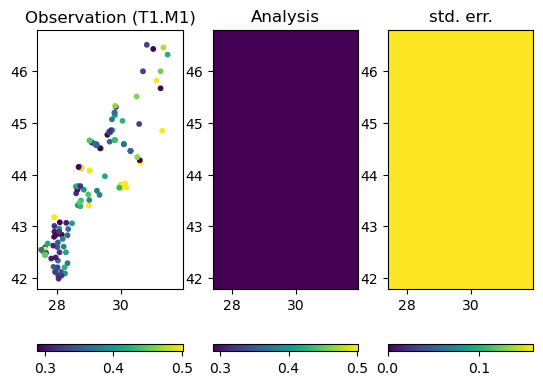

PyObject Text(0.5, 1.0, 'std. err.')

In [ ]:
# View the results

    clf();
    subplot(1,3,1); scatter(x,y,10,v); plmap(cl); title("Observation ($n)")
    subplot(1,3,2); pcolor(xi,yi,fi); plmap(cl); title("Analysis")
    subplot(1,3,3); pcolor(xi,yi,fi_err); plmap((0, 0.16)); title("std. err.")
    #savefig(joinpath(figdir,"analysis-$n.png"))